In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms as T
from torch.utils.data import SubsetRandomSampler as SRS
from torch.utils.data import DataLoader
from data.Dataset import Proteins
from sklearn.model_selection import train_test_split
from config import DefaultConfig
from models import resnet101
import time
import os

In [2]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [3]:
opt =DefaultConfig()

transform = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[.5,.5,.5], std=[.5,.5,.5])
])

dataset_AB42_SYN = Proteins(root=opt.root,transforms=transform)

# Split train and test sets 7:3
train_idx, val_test_idx = train_test_split(
    np.arange(len(dataset_AB42_SYN.labels)),
    test_size=0.3,
    stratify=dataset_AB42_SYN.labels
)

val_test_labels = [dataset_AB42_SYN.labels[i] for i in val_test_idx]
val_idx, test_idx = train_test_split(val_test_idx, test_size=0.66, stratify=val_test_labels)

train_sampler = SRS(train_idx)
val_sampler = SRS(val_idx)
test_sampler = SRS(test_idx)

train_loader = DataLoader(dataset_AB42_SYN, batch_size=10, sampler=train_sampler)
val_loader = DataLoader(dataset_AB42_SYN, batch_size=10, sampler=val_sampler)
test_loader = DataLoader(dataset_AB42_SYN, batch_size=10, sampler=test_sampler)

In [4]:
len(val_loader)

4

In [637]:
dataset_AB42_SYN.labels.count(0),dataset_AB42_SYN.labels.count(1)

(184, 176)

In [3]:
# Setup for Visdom
import visdom
vis = visdom.Visdom(env=u'protein')
vis.line([0],[0], win='train_acc', opts=dict(title='train acc', legend=['train acc']))
vis.line([0],[0], win='val_acc', opts=dict(title='val acc', legend=['val acc']))
#vis.line([0],[0], win='test', opts=dict(title='test loss & acc', legend=['loss', 'acc']))

Setting up a new session...


'val_acc'

In [4]:
vis.line([0],[0], win='train_loss', opts=dict(title='train loss',legend=['train loss']))
vis.line([0],[0], win='val_loss', opts=dict(title='val loss', legend=['val loss']))

'val_loss'

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=50, train_loader=train_loader, val_loader=val_loader):
    since = time.time()
    global_step = 0

    for epoch in range(num_epochs):
        print('Epoch {}{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        model.train()  # Set model to training mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
                        
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)  # 1 is the dimension
                loss = criterion(outputs, labels)

                # backward + optimize
                loss.backward()
                optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Decay learning rate

        epoch_loss = running_loss / train_loader.sampler.indices.shape[0]
        epoch_acc = running_corrects.item() / train_loader.sampler.indices.shape[0]

        print('{} Loss: {: .4f} Acc: {: .4f}'.format(
            'Train', epoch_loss, epoch_acc
        ))
        
        # plot for visdom
        global_step += 1
        vis.line([epoch_acc],[global_step], win='train_acc', update='append')
        vis.line([epoch_loss],[global_step], win='train_loss',update='append')
        scheduler.step()
        
        # start validation
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _,preds = torch.max(outputs,1)
            loss = criterion(outputs,labels)
            
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)
        
        epoch_val_loss = val_loss/val_loader.sampler.indices.shape[0]
        epoch_val_acc = val_corrects.item()/val_loader.sampler.indices.shape[0]
        
        # visdom plot
        vis.line([epoch_val_acc], [global_step],win='val_acc', update='append')
        vis.line([epoch_val_loss],[global_step], win='val_loss', update='append')
            
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60
    ))

    # load best model weights
    return model

In [11]:
def test(model, test_loader=test_loader):
    test_corrects = 0
    
    model.eval()
    
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _,preds = torch.max(outputs,1)
        
        test_corrects += torch.sum(preds == labels.data)
        
    test_acc = test_corrects.double()/test_loader.sampler.indices.shape[0]
    
    return test_corrects, test_acc

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_AB42_SYN = resnet101(pretrained=True)

num_in_ft = model_AB42_SYN.fc.in_features
model_AB42_SYN.fc = nn.Linear(num_in_ft, 2)
model_AB42_SYN.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_AB42_SYN = torch.optim.SGD(model_AB42_SYN.parameters(),
                                    lr=0.01, momentum=0.9)

scheduler = lr_scheduler.StepLR(optimizer_AB42_SYN,
                               step_size=5,gamma=0.8)

resnet101_AB42_SYN_1 = train_model(model_AB42_SYN, criterion,
                                  optimizer_AB42_SYN,scheduler,
                                  num_epochs=50)

Epoch 049
----------
Train Loss:  1.1461 Acc:  0.5159
Epoch 149
----------
Train Loss:  0.9625 Acc:  0.5437
Epoch 249
----------
Train Loss:  0.7268 Acc:  0.6627
Epoch 349
----------
Train Loss:  0.7571 Acc:  0.6349
Epoch 449
----------
Train Loss:  0.6566 Acc:  0.6825
Epoch 549
----------
Train Loss:  0.5866 Acc:  0.7143
Epoch 649
----------
Train Loss:  0.7249 Acc:  0.6190
Epoch 749
----------
Train Loss:  0.5854 Acc:  0.6905
Epoch 849
----------
Train Loss:  0.5308 Acc:  0.7698
Epoch 949
----------
Train Loss:  0.5886 Acc:  0.7183
Epoch 1049
----------
Train Loss:  0.5554 Acc:  0.7540
Epoch 1149
----------
Train Loss:  0.4219 Acc:  0.7976
Epoch 1249
----------
Train Loss:  0.3992 Acc:  0.8452
Epoch 1349
----------
Train Loss:  0.3784 Acc:  0.8413
Epoch 1449
----------
Train Loss:  0.2826 Acc:  0.8690
Epoch 1549
----------
Train Loss:  0.3796 Acc:  0.8413
Epoch 1649
----------
Train Loss:  0.2773 Acc:  0.8929
Epoch 1749
----------
Train Loss:  0.3655 Acc:  0.8333
Epoch 1849
---------

In [15]:
_,acc_train_1 = test(resnet101_AB42_SYN_1, train_loader)
acc_train_1

tensor(1., device='cuda:0', dtype=torch.float64)

In [16]:
_,acc_test_1 = test(resnet101_AB42_SYN_1)
acc_test_1

tensor(0.8519, device='cuda:0', dtype=torch.float64)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_AB42_SYN = resnet101(pretrained=True)

num_in_ft = model_AB42_SYN.fc.in_features
model_AB42_SYN.fc = nn.Linear(num_in_ft, 2)
model_AB42_SYN.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_AB42_SYN = torch.optim.SGD(model_AB42_SYN.parameters(),
                                    lr=0.01, momentum=0.9)

scheduler = lr_scheduler.StepLR(optimizer_AB42_SYN,
                               step_size=5,gamma=0.8)

resnet101_AB42_SYN_1 = train_model(model_AB42_SYN, criterion,
                                  optimizer_AB42_SYN,scheduler,
                                  num_epochs=50)

Epoch 049
----------
Train Loss:  1.2148 Acc:  0.5079
Epoch 149
----------
Train Loss:  0.9845 Acc:  0.5516
Epoch 249
----------
Train Loss:  0.9596 Acc:  0.4484
Epoch 349
----------
Train Loss:  0.8200 Acc:  0.5079
Epoch 449
----------
Train Loss:  0.8286 Acc:  0.5437
Epoch 549
----------
Train Loss:  0.8661 Acc:  0.5198
Epoch 649
----------
Train Loss:  0.6930 Acc:  0.5079
Epoch 749
----------
Train Loss:  0.7082 Acc:  0.5873
Epoch 849
----------
Train Loss:  0.5891 Acc:  0.7143
Epoch 949
----------
Train Loss:  0.5480 Acc:  0.7341
Epoch 1049
----------
Train Loss:  0.4931 Acc:  0.7738
Epoch 1149
----------
Train Loss:  0.4313 Acc:  0.8095
Epoch 1249
----------
Train Loss:  0.5096 Acc:  0.7738
Epoch 1349
----------
Train Loss:  0.4256 Acc:  0.8413
Epoch 1449
----------
Train Loss:  0.3373 Acc:  0.8532
Epoch 1549
----------
Train Loss:  0.2281 Acc:  0.9167
Epoch 1649
----------
Train Loss:  0.1999 Acc:  0.9206
Epoch 1749
----------
Train Loss:  0.2835 Acc:  0.8810
Epoch 1849
---------

In [6]:
_,acc_train_1 = test(resnet101_AB42_SYN_1, train_loader)
acc_train_1

tensor(0.9881, device='cuda:0', dtype=torch.float64)

In [7]:
_,acc_test_1 = test(resnet101_AB42_SYN_1)
acc_test_1

tensor(0.8796, device='cuda:0', dtype=torch.float64)

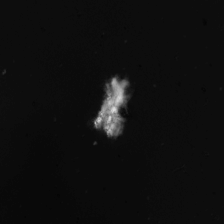

In [75]:
to_img = T.ToPILImage()
to_img(dataset_AB42_SYN[1][0])

## Add dropout

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_AB42_SYN = resnet101(pretrained=True)

# The size of each output sample is set to 2
num_in_ft = model_AB42_SYN.fc.in_features
model_AB42_SYN.fc = nn.Sequential(
                    nn.Linear(num_in_ft, 512),
                    nn.ReLU(),
                    nn.Dropout(0.5),
                    nn.Linear(512,128),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(128,32),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(32,2))

model_AB42_SYN.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_AB42_SYN = torch.optim.SGD(model_AB42_SYN.parameters(),
                                     lr=0.01, momentum=0.95)

scheduler = lr_scheduler.StepLR(optimizer_AB42_SYN,
                                step_size=5, gamma=0.8)

resnet101_AB42_SYN_2 = train_model(model_AB42_SYN, criterion,
                                 optimizer_AB42_SYN, scheduler,
                                 num_epochs=100)

Epoch 099
----------
Train Loss:  0.6967 Acc:  0.4921
Epoch 199
----------
Train Loss:  0.6952 Acc:  0.5278
Epoch 299
----------
Train Loss:  0.6934 Acc:  0.5397
Epoch 399
----------
Train Loss:  0.6483 Acc:  0.6389
Epoch 499
----------
Train Loss:  0.6827 Acc:  0.6310
Epoch 599
----------
Train Loss:  0.6703 Acc:  0.5595
Epoch 699
----------
Train Loss:  0.5323 Acc:  0.7738
Epoch 799
----------
Train Loss:  0.5595 Acc:  0.7183
Epoch 899
----------
Train Loss:  0.6028 Acc:  0.6786
Epoch 999
----------
Train Loss:  0.5306 Acc:  0.7738
Epoch 1099
----------
Train Loss:  0.5790 Acc:  0.7857
Epoch 1199
----------
Train Loss:  0.4338 Acc:  0.7976
Epoch 1299
----------
Train Loss:  0.4542 Acc:  0.8175
Epoch 1399
----------
Train Loss:  0.5546 Acc:  0.6905
Epoch 1499
----------
Train Loss:  0.3911 Acc:  0.8532
Epoch 1599
----------
Train Loss:  0.4438 Acc:  0.8413
Epoch 1699
----------
Train Loss:  0.3249 Acc:  0.8810
Epoch 1799
----------
Train Loss:  0.3430 Acc:  0.8690
Epoch 1899
---------

In [30]:
_,acc_train_2 = test(resnet101_AB42_SYN_2, train_loader)
acc_train_2

tensor(1., device='cuda:0', dtype=torch.float64)

In [31]:
_,acc_test_2 = test(resnet101_AB42_SYN_2)
acc_test_2

tensor(0.8519, device='cuda:0', dtype=torch.float64)

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_AB42_SYN = resnet101(pretrained=True)

# The size of each output sample is set to 2
num_in_ft = model_AB42_SYN.fc.in_features
model_AB42_SYN.fc = nn.Sequential(
                    nn.Linear(num_in_ft, 512),
                    nn.ReLU(),
                    nn.Dropout(0.5),
                    nn.Linear(512,128),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(128,32),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(32,2))

model_AB42_SYN.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_AB42_SYN = torch.optim.SGD(model_AB42_SYN.parameters(),
                                     lr=0.01, momentum=0.90)

scheduler = lr_scheduler.StepLR(optimizer_AB42_SYN,
                                step_size=5, gamma=0.8)

resnet101_AB42_SYN_3 = train_model(model_AB42_SYN, criterion,
                                 optimizer_AB42_SYN, scheduler,
                                 num_epochs=80)

Epoch 079
----------
Train Loss:  0.6926 Acc:  0.5397
Epoch 179
----------
Train Loss:  0.6837 Acc:  0.5476
Epoch 279
----------
Train Loss:  0.6140 Acc:  0.6944
Epoch 379
----------
Train Loss:  0.6402 Acc:  0.6508
Epoch 479
----------
Train Loss:  0.4675 Acc:  0.7937
Epoch 579
----------
Train Loss:  0.4903 Acc:  0.7659
Epoch 679
----------
Train Loss:  0.3709 Acc:  0.8452
Epoch 779
----------
Train Loss:  0.5048 Acc:  0.7937
Epoch 879
----------
Train Loss:  0.6239 Acc:  0.6627
Epoch 979
----------
Train Loss:  0.5476 Acc:  0.7857
Epoch 1079
----------
Train Loss:  0.4391 Acc:  0.8016
Epoch 1179
----------
Train Loss:  0.2588 Acc:  0.9206
Epoch 1279
----------
Train Loss:  0.3295 Acc:  0.8770
Epoch 1379
----------
Train Loss:  0.4481 Acc:  0.8056
Epoch 1479
----------
Train Loss:  0.2932 Acc:  0.8968
Epoch 1579
----------
Train Loss:  0.2796 Acc:  0.8968
Epoch 1679
----------
Train Loss:  0.2199 Acc:  0.9167
Epoch 1779
----------
Train Loss:  0.2204 Acc:  0.9325
Epoch 1879
---------

In [34]:
_,acc_train_3 = test(resnet101_AB42_SYN_3, train_loader)
acc_train_3

tensor(1., device='cuda:0', dtype=torch.float64)

In [36]:
_,acc_test_3 = test(resnet101_AB42_SYN_3)
acc_test_3

tensor(0.8519, device='cuda:0', dtype=torch.float64)

## Using visdom  

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_AB42_SYN = resnet101(pretrained=True)

# The size of each output sample is set to 2
num_in_ft = model_AB42_SYN.fc.in_features
model_AB42_SYN.fc = nn.Sequential(
                    nn.Linear(num_in_ft, 512),
                    nn.ReLU(),
                    nn.Dropout(0.5),
                    nn.Linear(512,128),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(128,32),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(32,2))

model_AB42_SYN.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_AB42_SYN = torch.optim.SGD(model_AB42_SYN.parameters(),
                                     lr=0.01, momentum=0.90)

scheduler = lr_scheduler.StepLR(optimizer_AB42_SYN,
                                step_size=5, gamma=0.8)

resnet101_AB42_SYN_4 = train_model(model_AB42_SYN, criterion,
                                 optimizer_AB42_SYN, scheduler,
                                 num_epochs=100)

Epoch 099
----------
Train Loss:  0.6943 Acc:  0.5397
Epoch 199
----------
Train Loss:  0.6923 Acc:  0.5238
Epoch 299
----------
Train Loss:  0.6704 Acc:  0.5595
Epoch 399
----------
Train Loss:  0.6069 Acc:  0.7262
Epoch 499
----------
Train Loss:  0.6512 Acc:  0.6389
Epoch 599
----------
Train Loss:  0.5176 Acc:  0.7421
Epoch 699
----------
Train Loss:  0.4305 Acc:  0.8175
Epoch 799
----------
Train Loss:  0.3324 Acc:  0.8690
Epoch 899
----------
Train Loss:  0.3662 Acc:  0.8571
Epoch 999
----------
Train Loss:  0.4237 Acc:  0.8214
Epoch 1099
----------
Train Loss:  0.2800 Acc:  0.9008
Epoch 1199
----------
Train Loss:  0.3162 Acc:  0.8849
Epoch 1299
----------
Train Loss:  0.2421 Acc:  0.9167
Epoch 1399
----------
Train Loss:  0.1143 Acc:  0.9762
Epoch 1499
----------
Train Loss:  0.2036 Acc:  0.9206
Epoch 1599
----------
Train Loss:  0.2614 Acc:  0.9008
Epoch 1699
----------
Train Loss:  0.2473 Acc:  0.9206
Epoch 1799
----------
Train Loss:  0.2550 Acc:  0.9048
Epoch 1899
---------

In [13]:
_,acc_test_4 = test(resnet101_AB42_SYN_4)
acc_test_4

tensor(0.9028, device='cuda:0', dtype=torch.float64)

In [14]:
_,acc_train_4 = test(resnet101_AB42_SYN_4,train_loader)
acc_train_4

tensor(1., device='cuda:0', dtype=torch.float64)

In [15]:
_, acc_val_4 = test(resnet101_AB42_SYN_4,val_loader)
acc_val_4

tensor(0.8889, device='cuda:0', dtype=torch.float64)

# Visualize the Conv 

In [22]:
from PIL import Image

In [387]:
def load_image(path):
    image = Image.open(path)
    plt.imshow(image)
    plt.title("Image succesfully loaded")
    return image

def normalize(image):
    transform = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[.5,.5,.5], std=[.5,.5,.5])
])
    image = transform(image)
    image = image.cuda()
    image = image.unsqueeze(0)
    return image

def predict(image):
    output = resnet101_AB42_SYN_4(image)
    _,pred = torch.max(output,1)
    return str(pred.item()), "AB-42" if pred.item() == 1 else "Alpha-syn"

def deprocess(image):
    return image * torch.Tensor([0.5, 0.5, 0.5]).cuda()  + torch.Tensor([0.5, 0.5, 0.5]).cuda()

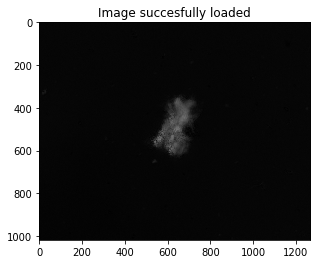

In [23]:
protein_1 = load_image("./data/AB42-SYN images/(AB-42)(S1)(Region 002)(RS1)(PS1)(Retardance Lin).png")

In [26]:
protein_1.size

(1269, 1018)

In [27]:
protein_1_normal = normalize(protein_1)
protein_1_normal.shape

torch.Size([1, 3, 224, 224])

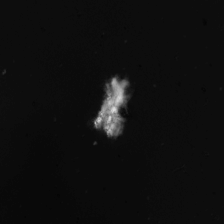

In [94]:
protein_2 = normalize(protein_1)

to_img(protein_2)

In [149]:
protein_2.shape

torch.Size([3, 224, 224])

In [150]:
protein_2.unsqueeze(0).shape

torch.Size([1, 3, 224, 224])

In [151]:
protein_2.unsqueeze(1).shape

torch.Size([3, 1, 224, 224])

In [154]:
p2 = protein_2.unsqueeze(0)
p2.squeeze().shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


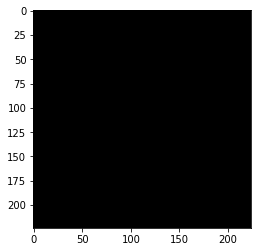

In [170]:
p2_test = protein_2.transpose(0,1)
p2_test = p2_test.transpose(1,2)

plt.imshow(p2_test.cpu())

In [171]:
p2_test = p2_test*torch.Tensor([0.5,0.5,0.5]).cuda() + torch.Tensor([0.5,0.5,0.5]).cuda()

In [ ]:
true_image = true_image * torch.Tensor([.5,.5,.5]).cuda() + torch.Tensor([.5,.5,.5]).cuda()

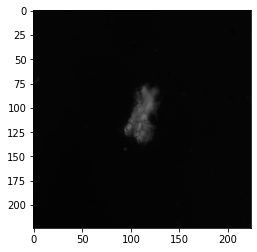

In [174]:
plt.imshow(p2_test.cpu())

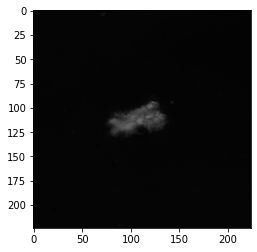

In [176]:
p2_test2 = protein_2.transpose(0,2)
p2_test2 = p2_test2*torch.Tensor([.5,.5,.5]).cuda() + torch.Tensor([.5,.5,.5]).cuda()
imgplot = plt.imshow(p2_test2.cpu())

In [122]:
protein_2 = protein_2.cuda()
predict(protein_2)

('1', 'AB-42')

## CNN heatmaps: Occlusion

In [284]:
def make_heatmap(model, image, true_class, k=8, stride=8):
    """
    Input image is of size(1,c,w,h)
    true class is a number corresponding to Imagenet classes
    k in the filter size(c,k,k)
    """
    heatmap = torch.zeros(int(((image.shape[2]-k)/stride) + 1), int(((image.shape[3]-k)/stride)+1))
    image = image.data
    
    i = 0
    a = 0
    while i<=image.shape[3]-k:
        j = 0
        b = 0
        while j<=image.shape[2]-k:
            h_filter = torch.ones(image.shape)
            h_filter[:,:,j:j+k,i:i+k] = 0
            temp_image = image.cuda()*h_filter.cuda()
            temp_softmax = model(temp_image)
            temp_softmax = torch.nn.functional.softmax(temp_softmax,dim=1).data[0]
            heatmap[a][b] = temp_softmax[true_class]
            j += stride
            b += 1
        i += stride
        a += 1
        
    image = image.squeeze()
    
    true_image = image.transpose(0,1)
    true_image = true_image.transpose(1,2)
    # Un_Normalize image
    true_image = true_image * torch.Tensor([.5,.5,.5]).cuda() + torch.Tensor([.5,.5,.5]).cuda() 
    
    # plot both images
    fig = plt.figure()

    
    a = fig.add_subplot(1,2,1)
    imgplot = plt.imshow(true_image.cpu())
    plt.title('Original Image')
    
    # Normalize the hearmap
    heatmap = np.uint8(255*heatmap)
    
    a = fig.add_subplot(1,2,2)
    imgplot = plt.imshow(heatmap)
    plt.title('Heatmap')
    
    return true_image, heatmap

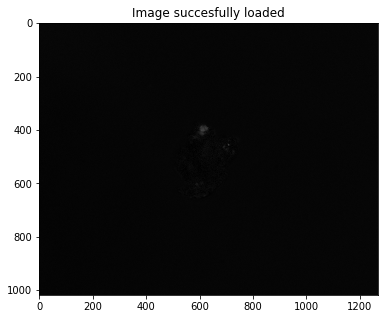

In [285]:
protein_2 = load_image("./data/AB42-SYN images/(AB-42)(S1)(Region 016)(RS1)(PS1)(Retardance Lin).png")

In [286]:
protein_2 = normalize(protein_2)

In [287]:
predict(protein_2)

('1', 'AB-42')

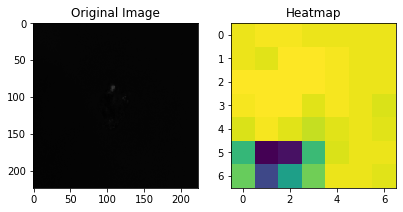

In [288]:
true_image, protein_heatmap = make_heatmap(resnet101_AB42_SYN_4, protein_2, 1,k=32,stride=32)

In [289]:
protein_heatmap

array([[252, 253, 253, 252, 252, 252, 252],
       [252, 251, 254, 254, 253, 252, 252],
       [254, 254, 254, 254, 253, 252, 252],
       [253, 254, 254, 251, 253, 252, 250],
       [250, 253, 251, 248, 251, 252, 251],
       [231, 185, 188, 232, 250, 252, 252],
       [238, 200, 224, 239, 252, 252, 251]], dtype=uint8)

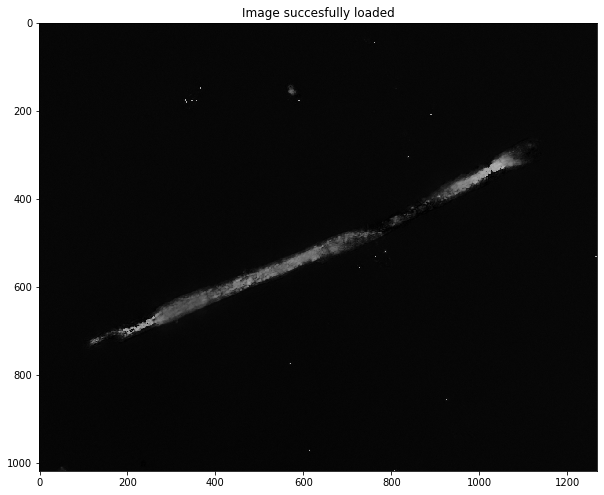

In [205]:
plt.rcParams['figure.figsize']=(10,10)
protein_4 = load_image("./data/images_AB42_SYN/(AB-42)(S1)(Region 004)(RS1)(PS1)(Retardance Lin).png")

In [207]:
protein_4 = normalize(protein_4)

In [208]:
predict(protein_4)

('1', 'AB-42')

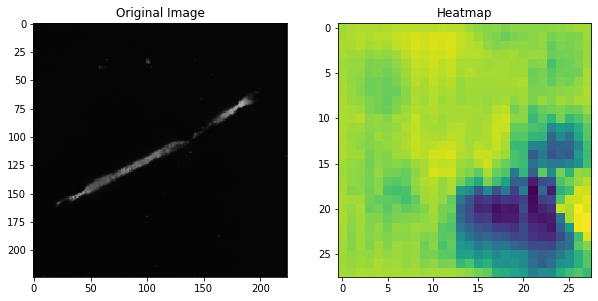

In [209]:
true_image_4, protein_heatmap_4 = make_heatmap(resnet101_AB42_SYN_3, protein_4, 1)

In [211]:
protein_20 = normalize(protein_20)
predict(protein_20)

('1', 'AB-42')

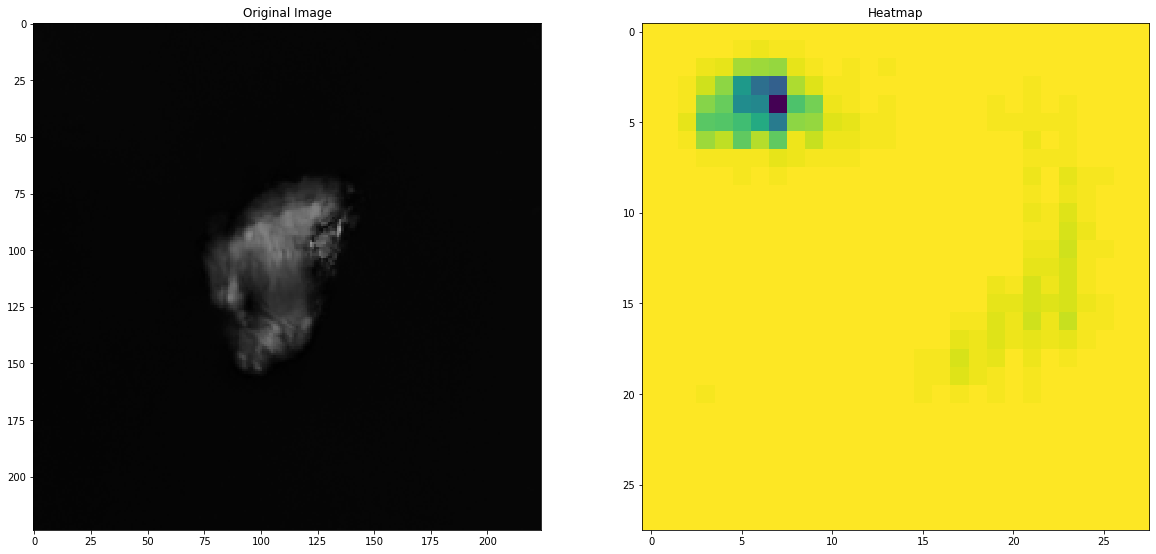

In [212]:
true_image_20, protein_heatmap_20 = make_heatmap(resnet101_AB42_SYN_3, protein_20, 1)

In [248]:
protein_heatmap_20

array([[254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254,
        254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254,
        254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254,
        254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254,
        254, 254, 254, 254],
       [254, 254, 254, 254, 253, 254, 253, 253, 253, 253, 252, 252, 249,
        252, 251, 253, 251, 253, 253, 253, 252, 254, 253, 254, 253, 254,
        254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254,
        254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254,
        254, 254, 254, 254],
       [254, 254, 254, 254, 253, 254, 254, 253, 252, 253, 254, 252, 247,
        252, 253, 253, 251, 253, 254, 253, 252, 254, 254, 254, 254, 254,
        254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254,
        254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254,
        254, 254, 254, 254],
       [254, 254, 254, 253, 253, 253,

array([[254, 254, 254, ..., 254, 254, 254],
       [254, 254, 254, ..., 254, 254, 254],
       [254, 254, 254, ..., 254, 254, 254],
       ...,
       [254, 254, 254, ..., 254, 254, 254],
       [254, 254, 254, ..., 254, 254, 254],
       [254, 254, 254, ..., 254, 254, 254]], dtype=uint8)

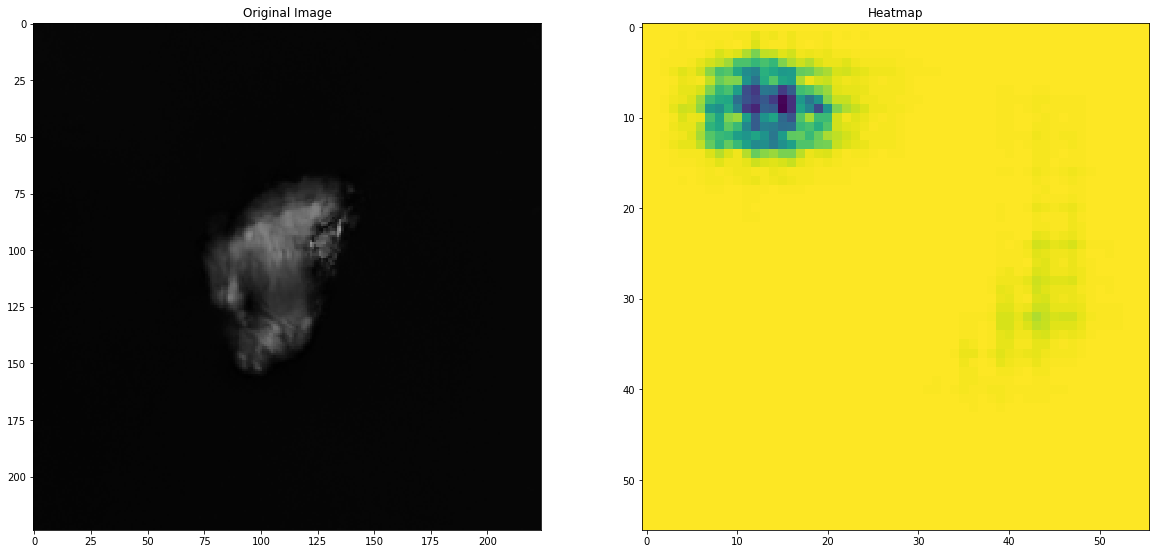

In [241]:
true_image_20, protein_heatmap_20 = make_heatmap(resnet101_AB42_SYN_3, protein_20, 1,k=4, stride=4)

In [243]:
protein_heatmap_20 

array([[254, 254, 254, ..., 254, 254, 254],
       [254, 254, 254, ..., 254, 254, 254],
       [254, 254, 254, ..., 254, 254, 254],
       ...,
       [254, 254, 254, ..., 254, 254, 254],
       [254, 254, 254, ..., 254, 254, 254],
       [254, 254, 254, ..., 254, 254, 254]], dtype=uint8)

In [215]:
protein_36 = normalize(protein_36)
predict(protein_36)

('1', 'AB-42')

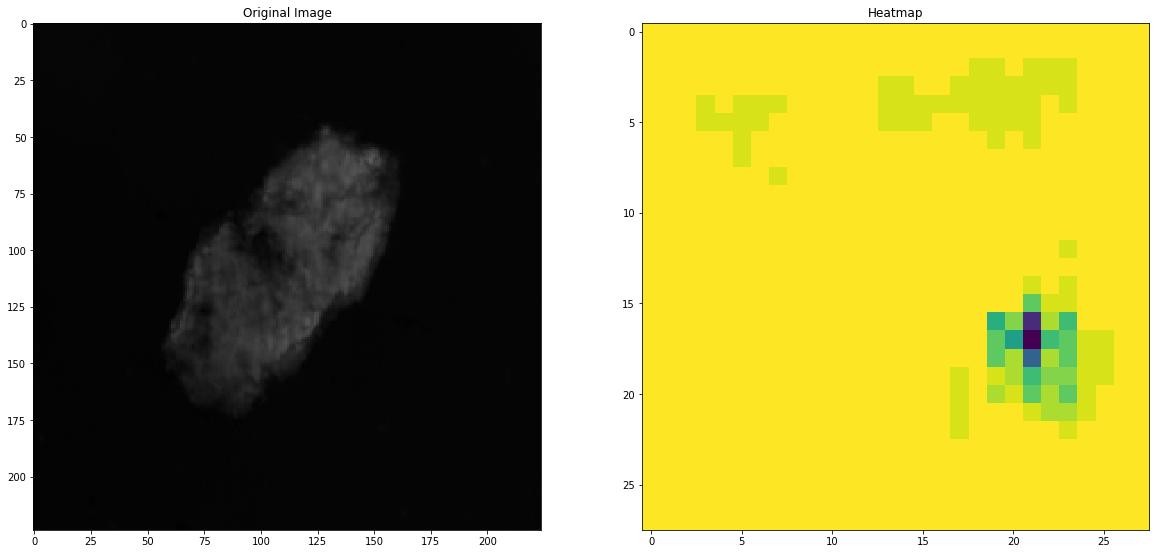

In [216]:
true_image_36, protein_heatmap_36 = make_heatmap(resnet101_AB42_SYN_3, protein_36, 1)

In [218]:
protein_a1 = normalize(protein_a1)
predict(protein_a1)

('0', 'Alpha-syn')

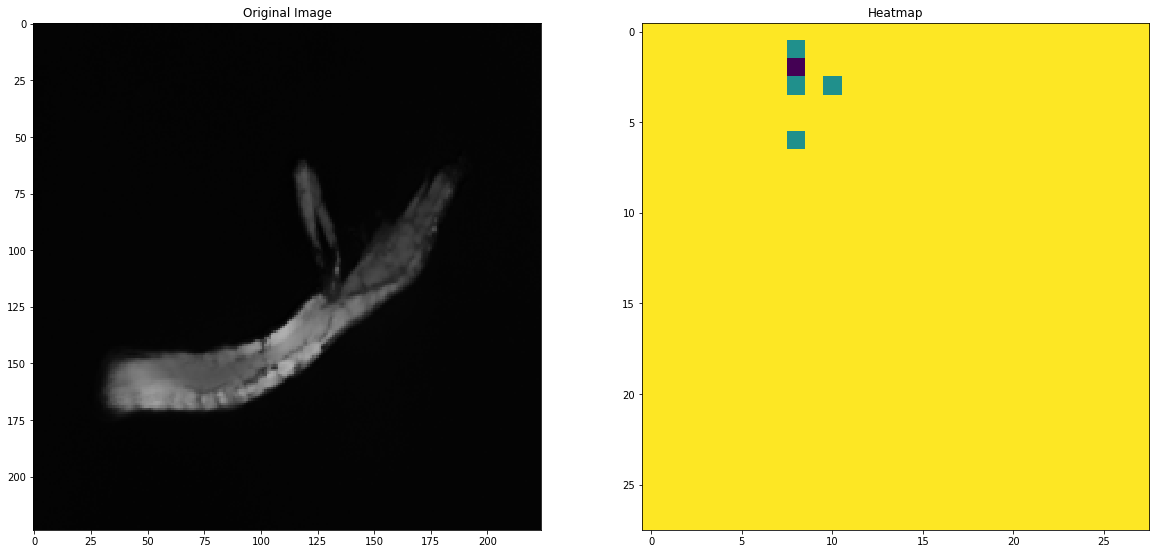

In [221]:
true_image_a1, protein_heatmap_a1 = make_heatmap(resnet101_AB42_SYN_3, protein_a1, 0)

In [240]:
protein_heatmap_a1

array([[254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254,
        254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254,
        254, 254],
       [254, 254, 254, 254, 254, 254, 254, 254, 253, 254, 254, 254, 254,
        254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254,
        254, 254],
       [254, 254, 254, 254, 254, 254, 254, 254, 252, 254, 254, 254, 254,
        254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254,
        254, 254],
       [254, 254, 254, 254, 254, 254, 254, 254, 253, 254, 253, 254, 254,
        254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254,
        254, 254],
       [254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254,
        254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254,
        254, 254],
       [254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254,
        254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254,
        254, 254],
       [25

In [226]:
protein_a2 = normalize(protein_a2)
predict(protein_a2)

('0', 'Alpha-syn')

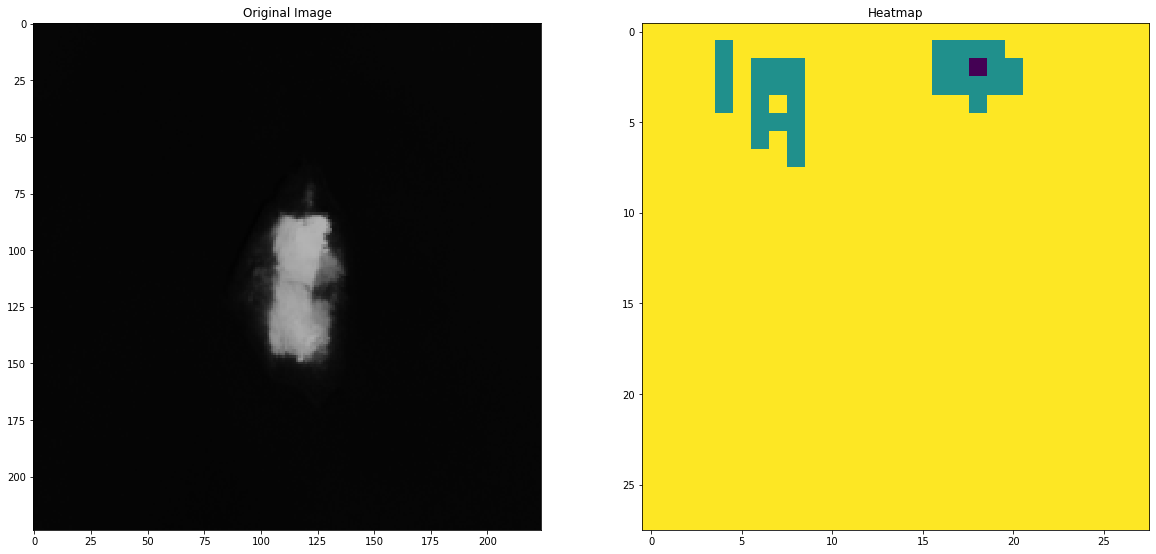

In [227]:
true_image_a2, protein_heatmap_a2 = make_heatmap(resnet101_AB42_SYN_3, protein_a2, 0)

## Another occlusion map 

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns

In [294]:
def second_occlusion(protein_image,model,label,occluding_size=16,occluding_stride=16):

    occluding_pixel=0
    
    _, _, height,width=protein_image.shape

    output_height = int(math.ceil((height-occluding_size)/occluding_stride+1))
    output_width = int(math.ceil((height-occluding_size)/occluding_stride+1))

    heatmap = np.zeros((output_height,output_width))

    for h in range(output_height):
        for w in range(output_width):
            #occluder region
            h_start = h*occluding_stride
            w_start = w*occluding_stride
            h_end = min(height, h_start+occluding_size)
            w_end = min(width, w_start+occluding_size)
            
            protein_copy = protein_image.clone()
            protein_copy[:,:,w_start:w_end,h_start:h_end] = occluding_pixel
            predict = model(protein_copy)
            prob = torch.nn.functional.softmax(predict,dim=1).data[0][label]
            heatmap[h,w] = prob #The probability of the correct class
            
    return heatmap

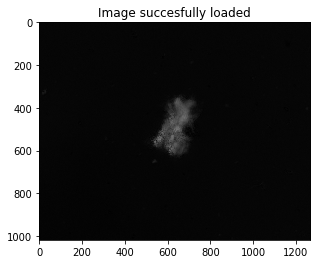

In [120]:
protein_1 = load_image("./data/AB42-SYN images/(AB-42)(S1)(Region 002)(RS1)(PS1)(Retardance Lin).png")
protein_1_normal = normalize(protein_1)

protein_1_heatmap = second_occlusion(protein_1_normal,resnet101_AB42_SYN_4,1)

In [135]:
protein_1_heatmap = second_occlusion(protein_1_normal,resnet101_AB42_SYN_4,1,occluding_size=64,occluding_stride=64)

<function matplotlib.pyplot.show(*args, **kw)>

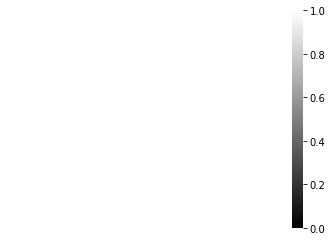

In [136]:
fig = sns.heatmap(protein_1_heatmap,xticklabels=False,yticklabels=False,cmap="gray",vmin=0,vmax=1)
plt.show

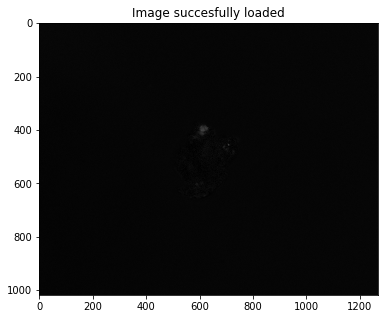

In [278]:
protein_2 = load_image("./data/AB42-SYN images/(AB-42)(S1)(Region 016)(RS1)(PS1)(Retardance Lin).png")
protein_2_normal = normalize(protein_2)

In [295]:
protein_2_heatmap = second_occlusion(protein_2_normal,resnet101_AB42_SYN_4,1,occluding_size=32,occluding_stride=32)

<function matplotlib.pyplot.show(*args, **kw)>

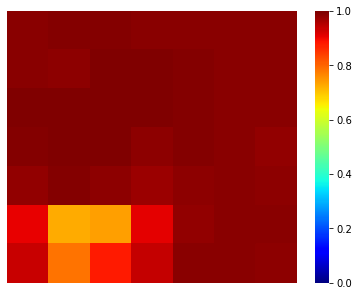

In [296]:
fig = sns.heatmap(protein_2_heatmap,xticklabels=False,yticklabels=False,cmap="jet",vmin=0,vmax=1)
plt.show

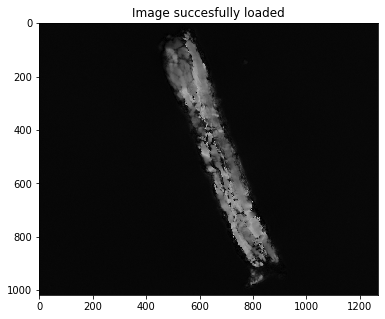

In [443]:
protein_2 = load_image("./data/AB42-SYN images/(AB-42)(U9)(633 Region 003)(RS1)(PS1)(Retardance Lin).png")
protein_2_normal = normalize(protein_2)

In [447]:
protein_2_heatmap = second_occlusion(protein_2_normal,resnet101_AB42_SYN_4,1,occluding_size=16,occluding_stride=16)

In [448]:
protein_2_heatmap.shape

(14, 14)

<function matplotlib.pyplot.show(*args, **kw)>

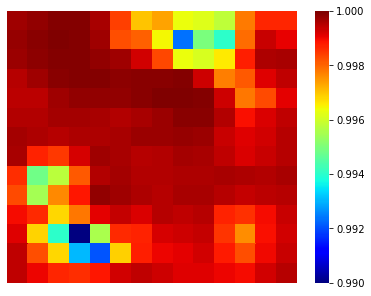

In [457]:
fig = sns.heatmap(protein_2_heatmap,xticklabels=False,yticklabels=False,cmap="jet",vmin=0.99,vmax=1)
plt.show

In [340]:
protein_2_heatmap.min()

0.9999551773071289

In [341]:
predict(protein_2_normal.cuda())

('1', 'AB-42')

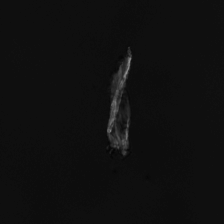

In [356]:
to_img(protein_2_normal.squeeze().cpu())

In [373]:
resnet101_AB42_SYN_4(protein_2_normal)

tensor([[-6.2102,  5.0865]], device='cuda:0', grad_fn=<AddmmBackward>)

In [350]:
resnet101_AB42_SYN_4(protein_2_normal)

tensor([[-6.2102,  5.0865]], device='cuda:0', grad_fn=<AddmmBackward>)

## Saliency maps 

In [549]:
def make_saliency_map(input,model,label):
    input.requires_grad=True
    output = model.forward(input)
    output[0][label].backward()
    #grads = input.grad.data.clamp(min=0)
    grads = input.grad.data.abs()
    gradsout = grads.squeeze()
    gradsout = gradsout.transpose(0,1)
    gradsout = gradsout.transpose(1,2)
    gradsout = np.amax(gradsout.cpu().numpy(), axis=2) # return the maximum value in RGB channel
    
    true_image = input.data
    true_image = true_image.squeeze()
    true_image = true_image.transpose(0,1)
    true_image = true_image.transpose(1,2)
    true_image = deprocess(true_image)
    
    fig = plt.figure()
    
    plot_win = fig.add_subplot(1,2,1)
    imgplot = plt.imshow(true_image.cpu())
    plt.title('Original Image')
    
    plot_win = fig.add_subplot(1,2,2)
    imgplot = plt.imshow(gradsout)
    plt.title('Saliency map')
    
    return true_image, gradsout

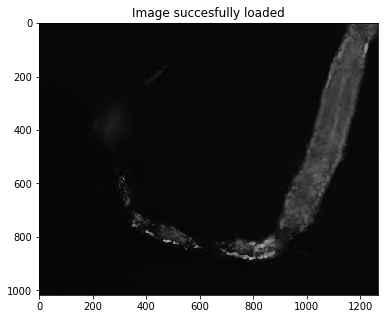

In [492]:
protein_2 = load_image("./data/AB42-SYN images/(Alpha-syn)(S1)(Region 017 A)(RS1)(PS1)(Retardance Lin).png")
protein_2_normal = normalize(protein_2) 

In [480]:
predict(protein_2_normal)

('0', 'Alpha-syn')

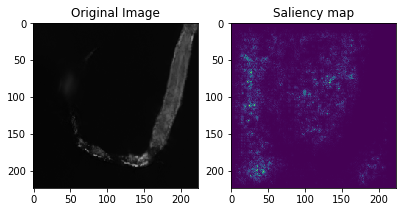

In [493]:
dog_sal = make_saliency_map(protein_2_normal,resnet101_AB42_SYN_4,0)

Text(0.5, 1.0, 'Saliency map')

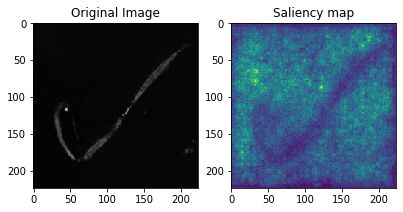

In [501]:
fig = plt.figure()
    
plot_win = fig.add_subplot(1,2,1)
imgplot = plt.imshow(true_image.cpu())
plt.title('Original Image')
    
plot_win = fig.add_subplot(1,2,2)
imgplot = plt.imshow(nout)
plt.title('Saliency map')

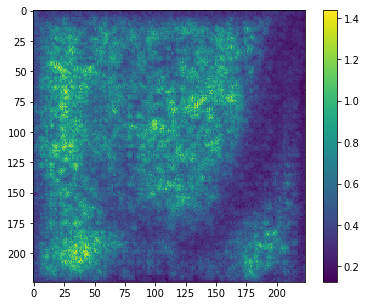

In [494]:
nout = np.power(dog_sal, 0.2)
plt.imshow(nout)
plt.colorbar()

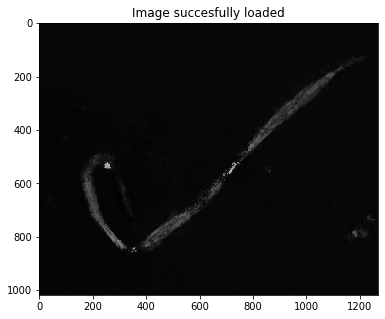

In [495]:
protein_2 = load_image("./data/AB42-SYN images/(Alpha-syn)(S1)(Region 032)(RS1)(PS1)(Retardance Lin).png")
protein_2_normal = normalize(protein_2)

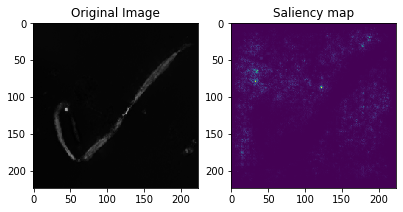

In [496]:
dog_sal = make_saliency_map(protein_2_normal,resnet101_AB42_SYN_4,0)

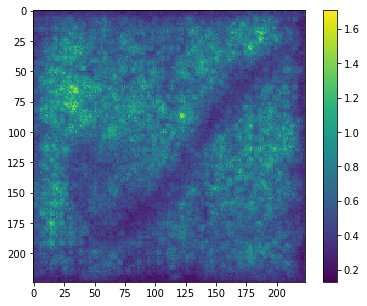

In [497]:
nout = np.power(dog_sal, 0.2)
plt.imshow(nout)
plt.colorbar()

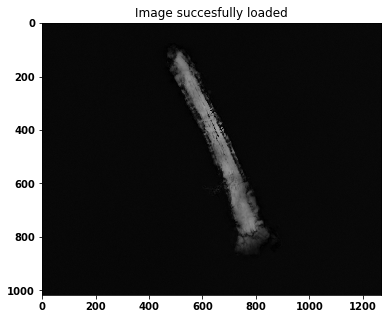

In [630]:
protein_2 = load_image("./data/AB42-SYN images/(Alpha-syn)(U3)(633 Region 010)(RS1)(PS1)(Retardance Lin).png")
protein_2_normal = normalize(protein_2)

In [631]:
predict(protein_2_normal)

('0', 'Alpha-syn')

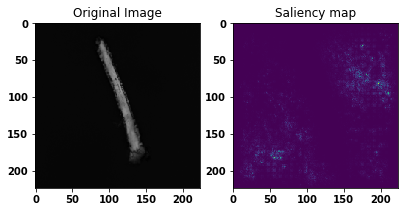

In [632]:
true_image, sal_map = make_saliency_map(protein_2_normal,resnet101_AB42_SYN_4,0)

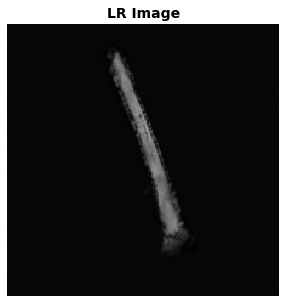

In [633]:
plt.rcParams['font.size'] = 10
plt.rcParams['font.weight'] = 'bold'

plt.imshow(true_image.cpu())
plt.title('LR Image',fontsize=14,fontweight='bold')
plt.axis('off') 

plt.savefig('LR image example 2.png')

In [1]:
nout = np.power(sal_map, 0.2)

plt.imshow(nout)
plt.title('Saliency map',fontsize=14,fontweight='bold')
plt.colorbar()
plt.axis('off') 
plt.savefig('Saliency map example 2.png')

NameError: name 'np' is not defined

In [635]:
protein_2_heatmap = second_occlusion(protein_2_normal,resnet101_AB42_SYN_4,0,occluding_size=16,occluding_stride=16)

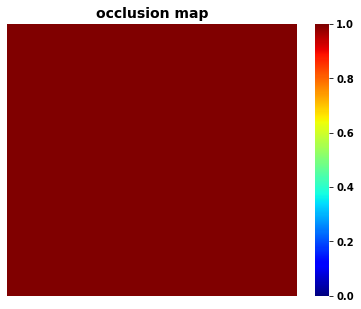

In [636]:
fig = sns.heatmap(protein_2_heatmap,xticklabels=False,yticklabels=False,cmap="jet",vmin=0,vmax=1)
plt.show
plt.title('occlusion map',fontsize=14,fontweight='bold')
plt.savefig('occlusion map example 2.png')

In [572]:
protein_2_heatmap.min()

0.9999068975448608

In [638]:
123

123

In [640]:
120/10

12.0

## Comparing with random forest 

In [3]:
from math import pi
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
# Train lda, support vector machine, random forest
from sklearn import svm
from scipy.stats import randint as sp_randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda
import os

In [6]:
datapath = os.getcwd() + "\\data\\dbt_633nm_AB42_SYN.csv"
df = pd.read_csv(datapath)

In [7]:
pd.isnull(df).any()

RegionFolder                         False
Subject                              False
Depolarization_Power_Deposit_Mean    False
Q_metric_Deposit_Mean                False
Anisotropy_Lin_Deposit_Mean          False
Anisotropy_Circ_Deposit_Mean         False
Polarizance_Lin_Deposit_Mean         False
Polarizance_Circ_Deposit_Mean        False
Diattenuation_Lin_Deposit_Mean       False
Diattenuation_Circ_Deposit_Mean      False
Retardance_Lin_Deposit_Mean          False
Retardance_Circ_Deposit_Mean         False
A_metric_Deposit_Mean                False
b_metric_Deposit_Mean                False
t_metric_Deposit_Mean                False
x_metric_Deposit_Mean                False
Depolarization_Power_Deposit_Std     False
Q_metric_Deposit_Std                 False
Anisotropy_Lin_Deposit_Std           False
Anisotropy_Circ_Deposit_Std          False
Polarizance_Lin_Deposit_Std          False
Polarizance_Circ_Deposit_Std         False
Diattenuation_Lin_Deposit_Std        False
Diattenuati

In [8]:
# Min-max scaling
# The Q metric
df[["Q_metric_Deposit_Mean", "Q_metric_Deposit_Std"]] = \
df[["Q_metric_Deposit_Mean", "Q_metric_Deposit_Std"]].divide(3) 

# The Linear retardance
df[["Retardance_Lin_Deposit_Mean", "Retardance_Lin_Deposit_Std"]] = \
df[["Retardance_Lin_Deposit_Mean", "Retardance_Lin_Deposit_Std"]].divide(180)

# The Circular retardance, Circular diattenuation , Circular polarizance
df[["Retardance_Circ_Deposit_Mean", "Retardance_Circ_Deposit_Std"]] = \
(df[["Retardance_Circ_Deposit_Mean", "Retardance_Circ_Deposit_Std"]]+ 180).divide(360)

# The Circular diattenuation
df[["Diattenuation_Circ_Deposit_Mean", "Diattenuation_Circ_Deposit_Std"]] = \
(df[["Diattenuation_Circ_Deposit_Mean", "Diattenuation_Circ_Deposit_Std"]]+ 1).divide(2)

# The Circular polarizance
df[["Polarizance_Circ_Deposit_Mean", "Polarizance_Circ_Deposit_Std"]] = \
(df[["Polarizance_Circ_Deposit_Mean", "Polarizance_Circ_Deposit_Std"]]+ 1).divide(2)

# The MMT parameters
df[["A_metric_Deposit_Mean", "A_metric_Deposit_Std"]] = \
(df[["A_metric_Deposit_Mean", "A_metric_Deposit_Std"]] + 1).divide(2)

df[["t_metric_Deposit_Mean", "t_metric_Deposit_Std"]] = \
(df[["t_metric_Deposit_Mean", "t_metric_Deposit_Std"]] + 1).divide(2)

df[["x_metric_Deposit_Mean", "x_metric_Deposit_Std"]] = \
(df[["x_metric_Deposit_Mean", "x_metric_Deposit_Std"]] + pi/4).divide(pi/2)

In [9]:
# Statistics of the number 
print("  Number of each class \n"
      "  AB-42: " + str(sum(df["Subject"] == 'AB-42')) + "\n" + 
      "  Alpha-syn: " + str(sum(df['Subject']=='Alpha-syn')) + "\n"
     )

  Number of each class 
  AB-42: 163
  Alpha-syn: 171



In [10]:
# Define classifiers
def train_lda(data_train,label_train):
    clf_lda = lda(store_covariance=True)
    
    # train
    clf_lda.fit(data_train,label_train)
    lda_cv_score = cross_val_score(clf_lda, data_train, label_train, cv=10, scoring="accuracy")
    return clf_lda, lda_cv_score


def train_rf(data_train, label_train, std=False):
    wdict_rf = {0: 1, 1: 1}
    clf_rf = RandomForestClassifier(n_jobs=-1)
    param_dist = {"n_estimators": sp_randint(100, 1000),
                  "bootstrap": [True, False],
                  "max_features": sp_randint(1, 6) if std else sp_randint(1,4),
                  "min_samples_split": sp_randint(2,3),
                  "criterion": ["gini", "entropy"]}
    n_iter_search = 100
    rs_rf = RandomizedSearchCV(clf_rf, param_distributions=param_dist,
                                      n_iter=n_iter_search, cv=10, n_jobs=-1)    

    # train
    rs_rf.fit(data_train, label_train)
    return rs_rf


def train_svm(data_train, label_train):
    wdict_svm = {0: 1, 1: 1}
    clf_svm = svm.SVC(class_weight=wdict_svm,probability=True)
    # optimize the parameters
    param_dist = {"kernel": ["rbf", "poly",'sigmoid'], 
                  "degree": [1, 2, 3],
                  "gamma": [0.001, 0.01, 0.1], 
                  "shrinking": [True, False]
                  }
    n_iter_search = 50
    rs_svm = RandomizedSearchCV(clf_svm, param_distributions=param_dist,
                                      n_iter=n_iter_search, cv=10, n_jobs=-1)
    # train
    rs_svm.fit(data_train, label_train)
    return rs_svm

In [11]:
# Define a function for inputing stats from classifier to dataframe
def metric_scores(m_clf,mname, truevalt, predictvalt,LDA=False,lda_cv_score=None):
    
    trueval = truevalt.copy()
    predictval = predictvalt.copy()
    accuracy = accuracy_score(trueval, predictval)
    precision = precision_score(trueval, predictval)
    recall = recall_score(trueval, predictval)
    specificity = recall_score(trueval, predictval, pos_label=0)
    # CV score of the best_estimator
    cvscore = np.mean(lda_cv_score) if LDA else m_clf.best_score_
        
    df_scores = pd.DataFrame({"Method": mname, "Accuracy": [accuracy], "Precision": [precision], "Sensitivity (Recall)": [recall], 
                              "Specificity": [specificity], "Mean accuracy": [cvscore]})
    return df_scores

def train_models(X_train_in, X_test_in, y_train_in, y_test_in,std=False):  
    df_result = pd.DataFrame({"Method": [], "Accuracy": [], "Precision": [], "Sensitivity (Recall)": [], 
                              "Specificity": [], "Mean accuracy": []})
    # lda
    rs_lda_t,lda_cv_score = train_lda(X_train_in, y_train_in)
    y_lda_predict = rs_lda_t.predict(X_test_in)
    df_temp1 = metric_scores(rs_lda_t, "LDA", y_test_in, y_lda_predict,LDA=True,lda_cv_score=lda_cv_score)
    df_result = df_result.append(df_temp1)
    
    # svm
    rs_svm_t = train_svm(X_train_in, y_train_in)
    y_svm_predict = rs_svm_t.predict(X_test_in)
    df_temp2 = metric_scores(rs_svm_t, "SVM", y_test_in, y_svm_predict)
    df_result = df_result.append(df_temp2)
    # rf
    rs_rf_t = train_rf(X_train_in, y_train_in,std=std)
    y_rf_predict = rs_rf_t.predict(X_test_in)    
    df_temp3 = metric_scores(rs_rf_t, "RF", y_test_in, y_rf_predict)
    df_result = df_result.append(df_temp3)
    return df_result, rs_lda_t, y_lda_predict, rs_svm_t, y_svm_predict, rs_rf_t, y_rf_predict

def fimportance_dataframe(name, score):
    feature_importance_table = pd.DataFrame({"Metric": [], "Importance in percentage":[]})
    for name, score in zip(name,score):
        feature_importance_add = pd.DataFrame({"Metric": name, "Importance in percentage":[score]})
        feature_importance_table = feature_importance_table.append(feature_importance_add)
    
    feature_importance_table = feature_importance_table[['Metric','Importance in percentage']]
    feature_importance_table = feature_importance_table.sort_values('Importance in percentage', ascending=False)
    
    return feature_importance_table

def data_preprocess(random_seed):
    
    df['Subject'][df['Subject']=='AB-42'] = 1
    df['Subject'][df['Subject']=='Alpha-syn'] = 0
    
    metric_data = df.values[:,1:]
    metric_label = df["Subject"].values
    metric_label = metric_label.astype('int')
    
    X_metric_train, X_metric_test, y_metric_train, y_metric_test = train_test_split(metric_data, metric_label, test_size=0.2, random_state=random_seed)
    return X_metric_train, X_metric_test, y_metric_train, y_metric_test

In [12]:
df.set_index(["RegionFolder"], inplace=True)

In [713]:
X_train_1, X_test_1, y_train_1, y_test_1 = data_preprocess(42)

result_1, lda_model_1, lda_pred_val_1, svm_model_1, svm_pred_val_1, rf_model_1, rf_pred_val_1 = \
                                                train_models(X_train_1, X_test_1, y_train_1,y_test_1,std=True)

C:\Users\y63qiu\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\y63qiu\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\y63qiu\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [714]:
result_1.set_index(["Method"], inplace=True)
result_1 

,Accuracy,Precision,Sensitivity (Recall),Specificity,Mean accuracy
Method,,,,,
LDA,0.552239,0.551724,0.484848,0.617647,0.550855
SVM,0.507463,0.000000,0.000000,1.000000,0.512963
RF,0.656716,0.656250,0.636364,0.676471,0.666952


In [719]:
feature_names = list(df.columns[1:].values)
feature_names_1 = feature_names[:28]

feature_importance_1 = rf_model_1.best_estimator_.feature_importances_
importance_table_1 = fimportance_dataframe(feature_names_1,feature_importance_1)

importance_table_1.set_index(["Metric"])

,Importance in percentage
Metric,
Diattenuation_Lin_Deposit_Mean,0.054659
Diattenuation_Lin_Deposit_Std,0.047659
Polarizance_Lin_Deposit_Mean,0.046756
Anisotropy_Lin_Deposit_Mean,0.043904
Diattenuation_Circ_Deposit_Mean,0.043082
Retardance_Circ_Deposit_Std,0.042943
Anisotropy_Lin_Deposit_Std,0.042900
Polarizance_Lin_Deposit_Std,0.040307
Polarizance_Circ_Deposit_Std,0.040247


In [18]:
X_train_1, X_test_1, y_train_1, y_test_1 = data_preprocess(20)

result_1, lda_model_1, lda_pred_val_1, svm_model_1, svm_pred_val_1, rf_model_1, rf_pred_val_1 = \
                                                train_models(X_train_1, X_test_1, y_train_1,y_test_1,std=True)

C:\Users\y63qiu\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\y63qiu\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\y63qiu\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
result_1.set_index(["Method"], inplace=True)
result_1 

,Accuracy,Precision,Sensitivity (Recall),Specificity,Mean accuracy
Method,,,,,
LDA,0.582090,0.525000,0.700000,0.486486,0.573647
SVM,0.552239,0.000000,0.000000,1.000000,0.475926
RF,0.686567,0.628571,0.733333,0.648649,0.618803


In [15]:
feature_names = list(df.columns[1:].values)
feature_names_1 = feature_names[:28]

feature_importance_1 = rf_model_1.best_estimator_.feature_importances_
importance_table_1 = fimportance_dataframe(feature_names_1,feature_importance_1)

importance_table_1.set_index(["Metric"])

,Importance in percentage
Metric,
Diattenuation_Lin_Deposit_Mean,0.048517
Diattenuation_Lin_Deposit_Std,0.048118
Diattenuation_Circ_Deposit_Mean,0.043219
Retardance_Circ_Deposit_Std,0.043077
Polarizance_Lin_Deposit_Mean,0.041143
Polarizance_Circ_Deposit_Std,0.040426
Polarizance_Lin_Deposit_Std,0.040204
Anisotropy_Circ_Deposit_Std,0.036459
Anisotropy_Lin_Deposit_Mean,0.036002


In [16]:
X_train_1, X_test_1, y_train_1, y_test_1 = data_preprocess(10)

result_1, lda_model_1, lda_pred_val_1, svm_model_1, svm_pred_val_1, rf_model_1, rf_pred_val_1 = \
                                                train_models(X_train_1, X_test_1, y_train_1,y_test_1,std=True)

C:\Users\y63qiu\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\y63qiu\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\y63qiu\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
result_1.set_index(["Method"], inplace=True)
result_1 

,Accuracy,Precision,Sensitivity (Recall),Specificity,Mean accuracy
Method,,,,,
LDA,0.567164,0.538462,0.65625,0.485714,0.572365
SVM,0.522388,0.000000,0.00000,1.000000,0.509259
RF,0.597015,0.586207,0.53125,0.657143,0.648291


In [19]:
result_1.set_index(["Method"], inplace=True)
result_1 

,Accuracy,Precision,Sensitivity (Recall),Specificity,Mean accuracy
Method,,,,,
LDA,0.522388,0.485714,0.548387,0.500000,0.583618
SVM,0.537313,0.000000,0.000000,1.000000,0.505556
RF,0.701493,0.641026,0.806452,0.611111,0.674929


In [20]:
a = [1,2,3]

In [21]:
len(a)

3

In [22]:
a = 123

In [24]:
b = str(a)

In [25]:
b

'123'

In [26]:
b[1]

'2'

In [27]:
len(b)

3

In [30]:
int(1.5)

1

In [31]:
3/2

1.5

In [34]:
5//2

2

In [35]:
3//2

1

In [37]:
for i in range(0,1):
    print(i)

0


In [41]:
len(str(123))//2

1

In [42]:
len(str(0))

1

In [43]:
1//2

0

In [46]:
for i in range(0,0):
    print (i)

In [47]:
3//2

1

In [49]:
for i in range(0,1):
    print(i)

0
